# Predicting diurnal variability from daily weather data

# Upsampling weather timeseries for ecosystem modeling

### Samuli Launiainen 3.4.2023

### Motivation

Biogeophysical and -chemical processes (e.g. photosynthetic uptake, decomposition, surface temperature regulation) are typically highly *non-linear* with respect to their environmental drivers. Environmental variables, such as air (Tair, degC) or soil (Tsoil) temperature, air humidity (H2O, mmol/mol), global radiation (Rg, Wm-2), wind speed (U, ms-1) and precipitation (Prec, mm), have strong seasonal and diurnal cycles, are affected by the weather history, and are highly interdependent. Thus, the timeseries are both highly autocorrelated and have (lagged) cross-covariance structure that varies in time.

Many of the non-linear ecosystem processes can be well theoretically described and modelled accurately using high-resolution (e.g. 30min or hourly) data that preserves *true* diurnal patterns and lags between different environmental drivers. However, when data is aggregated to daily or lower resolution, the non-linearity becomes a problem for predicting ecosystem processes. In these timescales, the processes are typically modelled using semi-empirical models trained (parameterized) against measurements. This approach as at least two important drawbacks: 

1) The theoretical understanding and vast information derived e.g. from leaf physiology and gas-exchange research (such as leaf traits and their functional role) is abandoned,

2) Model applied across disciplines, research questions and timescales are not coherent, resulting to large uncertainty in predictions, loss of synergies and poor utilization of the best knowledge in applied questions. This is particularly important for practically relevant applications and predicting the impacts of management and climate change on ecosystem processes and e.g. resulting forest or crop growth and greenhouse gas (GHG) balances.

In Finland, Finnish Met. Institute provides daily gridded weather data at 10x10 km (1x1km since 2016) grid, and many climate model projections are available at daily timescale. *Note however that Euro-CORDEX gives climate projections for Europe at 0.11 degree (EUR-11, ~12.5km) / 3h resolution.*

### We need predictive tools in form of machine-learning (ML) models to:

1) Downscale past and current daily weather observations or climate model predictions to sub-daily (1/2h or 1h) resolution for long-term simulations not possible with the recent high-resolution weather data,

2) To gap-fill measured (site-level) 1/2h meteorological variables using daily weather observations, for accurate simulations of recent decades GHG and water fluxes, and interpreting ecosystem functioning.

3) ... or to post-process (correct) the process-model predictions for any biases in daily magnitude, varibility and trends that may emerge from using daily averaged forcing data instead of sub-daily.

High-frequency weather and flux timeseries, spanning for a decade of longer, exist from e.g. SMEAR -site network in Finland and from Fluxnet (global) and ICOS (Europe). Assuming autocorrelation and cross-covariance structure (relationships between variables and their diurnal courses) are static across decadal timescales, we can use models trained against past data at a given location to predict diurnal variabilty in future climate scenarios. Moreover, including spatially distributed data in model training allows downscaling gridded weather or climate data.

### Goal

The goal here is to define the problem, demonstrate weather data and describe the idea how to address **Problems 1 & 2**. For this, I use observations from SMEAR I Värriö research station in Salla, Nuortitunturi 2013--2022. Without nearly *any knowledge of the methodology*, the Random Forest (RF) regression is blindly used to predict high-frequency timeseries from daily weather observations and theoretical clear-sky radiation. 


In [1]:
import matplotlib.pyplot as plt
#import hvplot.pandas  # noqa
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import preprocessing

# for smooth output, ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def rf_crossvalidate(X, Y, test_size=0.3, nfolds=5, n_estimators=10):
    """
    Fits Random Forest model to data and performs nfold cross-validation
    Args:
        X (N x marray) - features
        Y (N x1 array) - dependent variable
        test_size (-) - fraction of test data
        nfolds (-) - N-fold cross-validation
        n_estimators (-) - nr. estimators, see sklearn tutorial
    Returns:
        rf - random forest instance
        scaler_X, scaler_Y - StandardScaler instance
        cv_score - cross-validation score (R2) mean
        score - test score (R2)
    """
    
    if len(Y.shape) == 1:
        Y = Y.reshape(-1,1)
    if len(X.shape) == 1:
        X = X.reshape(-1,1)
        
    # divide train and test data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=0)
    
    # preprocess
    scaler_X = preprocessing.StandardScaler().fit(X_train)
    scaler_Y = preprocessing.StandardScaler().fit(Y_train)
    
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)
    
    Y_train = scaler_Y.transform(Y_train)
    Y_test = scaler_Y.transform(Y_test)
    
    # cross-validation
    rf = RandomForestRegressor(n_estimators=n_estimators).fit(X_train, Y_train)
    # think R2 is used here?
    cv_score = np.mean(cross_val_score(rf, X, Y, cv=nfolds))
    print('cross-validation score r2', cv_score)
    
    rf = RandomForestRegressor(n_estimators=n_estimators).fit(X_train, Y_train)
    score = rf.score(X_test, Y_test)
    print('test score r2', score)
    
    return rf, scaler_X, scaler_Y, cv_score, score

In [3]:
# --- compute theoretical clear-sky radiation on horizontal surface from DOY and zenith angle

def clear_sky_rad(doy, zen):
    
    doy = np.minimum(doy, 365)
    # extraterrestrial radiation is function of doy
    I0 = 1367.7 * (1 + 0.033*np.cos(2*np.pi/365 * doy))
    # Berger–Duffie (BD) model (1979) [1]:
    y  = np.maximum(0.0, I0 *0.70* np.cos(zen))
    return y

### Load and process Värriö 30min weather data

1) compute theoretical clear-sky global radiation (Rg0) at Värriö. Rg0 = f(Zen) == f(doy, time, lat, lon) depends on site location and time. This gives us insights on diurnal variablity of all timeseries, as they are often correlated with incoming light. Append to data

2) Prepare daily data: 'ddata' - dataframe with predictor variables



In [4]:
# --- read datafile
ffile = r'c:\data\GFB\FI-Var\proc\FI-Var_forcing_2013-2022.dat'

dat = pd.read_csv(ffile, sep=';')
t = pd.to_datetime(dat[['Year', 'Month', 'Day', 'Hour', 'Minute']])
dat.index = t

# global radiation and clear-sky radiation at surface
dat['Rg'] = dat['dirPar'] + dat['diffPar'] + dat['dirNir'] + dat['diffNir']
dat['Rg0'] = clear_sky_rad(dat['doy'].values, dat['Zen'].values)

cols = list(dat.columns)

x = dat[['doy', 'Zen', 'Prec', 'P', 'Tair', 'H2O', 'Rg', 'Rg0']]


#-- create daily data

dave = x.resample('D').mean()
dave['Prec'] = x['Prec'].resample('D').sum()

dmin = x[['Tair', 'H2O']].resample('D').min()
dmin.columns = [c + '_min' for c in dmin.columns]

dmax = x[['Tair', 'H2O']].resample('D').max()
dmax.columns = [c + '_max' for c in dmax.columns]

# -- this is dataframe we use as potential predictors
ddata = pd.concat([dave, dmin, dmax], axis=1)
ddata = ddata.resample('30min').ffill()
ddata = ddata.reindex(index=x.index)
ddata = ddata.fillna(method='ffill')

ddata['Zen'] = x['Zen']
#ddata['Rg0'] = x['Rg0']

print('Predictor variables: ', list(ddata.columns))
del dave, dmin, dmax

Predictor variables:  ['doy', 'Zen', 'Prec', 'P', 'Tair', 'H2O', 'Rg', 'Rg0', 'Tair_min', 'H2O_min', 'Tair_max', 'H2O_max']


### Select *independent* training and test periods from data

In [5]:
# training data 2013 - 2015
ixt = np.where(x.index.year<2016)[0]
# test data 2016 - 2022
ixp = np.where(x.index.year>=2016)[0]

### Learn and predict *Tair*, *H2O* and *Rg* jointly with single RandomForest model

### Features are ['Rg0', 'Tair', 'Tair_min', 'Tair_max', 'H2O', 'Rg', 'Prec'].

Rg0 is 30min theoretical clear-sky radiation, other are daily. Tair_min and Tair_max correspond to daily minimum and maximum temperature. These variables are available / can be computed from everywhere

In [6]:
# target variables: 30min timeseries

v =['Tair', 'H2O', 'Rg']
Y = x[v].iloc[ixt].values

# --- predictors
# Rg0 is 30min theoretical clear-sky radiation, other are daily. 
# These variables are available / can be computed from everywhere
pcols = ['Rg0', 'Tair', 'Tair_min', 'Tair_max', 'H2O', 'Rg', 'Prec']
X = ddata.iloc[ixt].values
t = x.index[ixt]

# train and cross-validate Random Forest
rf, scaler_X, scaler_Y, cv_score, score = rf_crossvalidate(X, Y, test_size=0.3, nfolds=5, n_estimators=10)

# prediction to full train set
# scaler's are built from train data alone
Ytpred = scaler_Y.inverse_transform(rf.predict(scaler_X.transform(X)))
print('score (R2) in train set: %.2f' % rf.score(scaler_X.transform(X), 
                                               scaler_Y.transform(Y))
      )

# prediction to independent test period
Yp = x[v].iloc[ixp].values
Xp = ddata.iloc[ixp].values
tp = x.index[ixp]

Ypred = scaler_Y.inverse_transform(rf.predict(scaler_X.transform(Xp)))
print('score (R2) in test set: %.2f' % rf.score(scaler_X.transform(Xp),
                                              scaler_Y.transform(Yp))
      )


cross-validation score r2 0.8738979775830007
test score r2 0.9078833401285928
score (R2) in train set: 0.96
score (R2) in test set: 0.92


## Plot graphs

### We want that:

1) Daily averages are preserved (no bias or trends are introduced)

2) Daily amplitudes (when present in ddata) are reproduced (diurnal variability is recovered)

3) High-frequeccy 'noise' in prediction is minimized

4) Autocorrelation and cross-covariance strucures preserved

### Which ML approaches should be used - and which are the relevant metrics? 

Are there common standards how to 'share' trained models? In Python, we can of course train models and store model objects e.g. via Pickle...


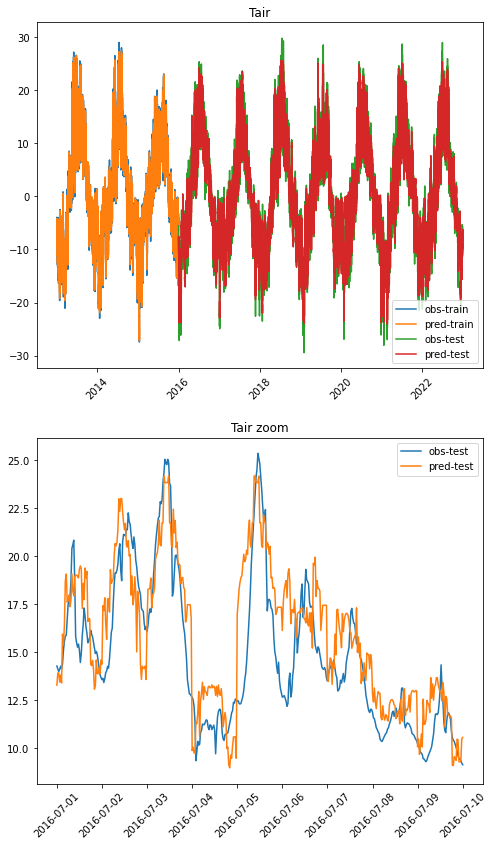

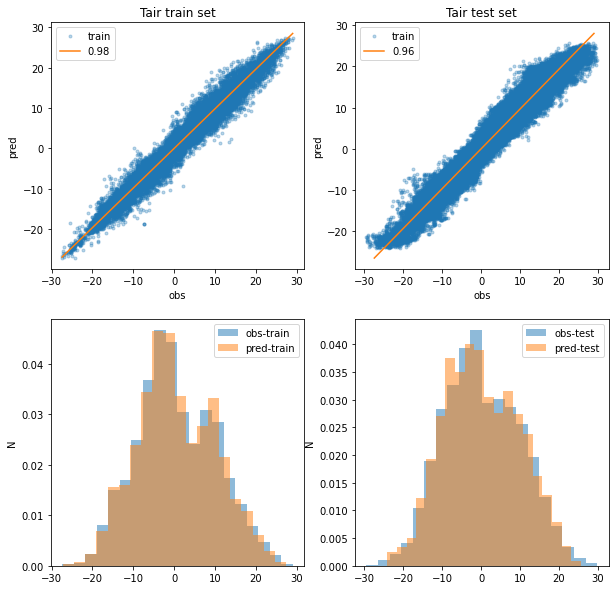

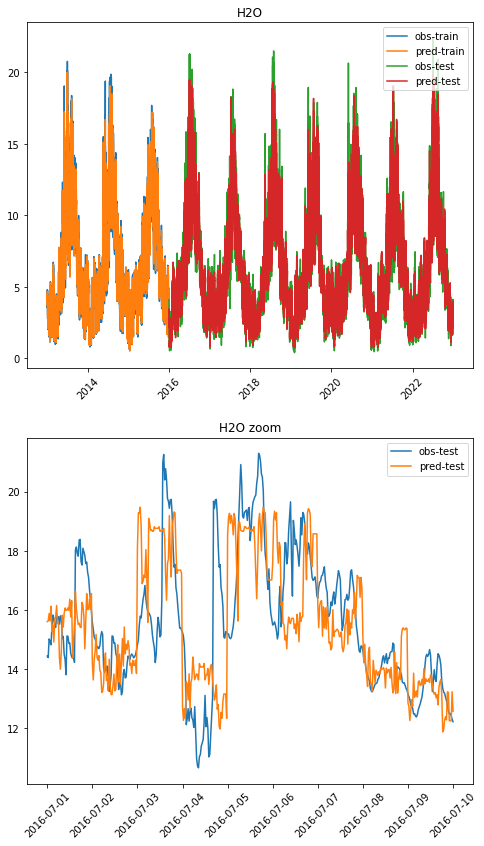

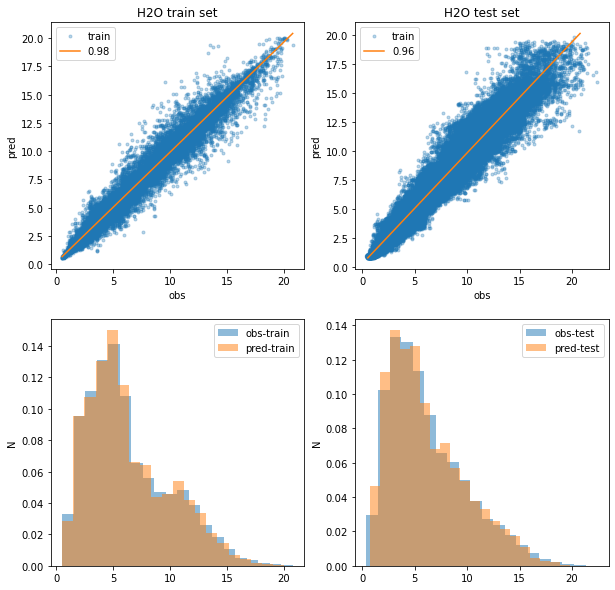

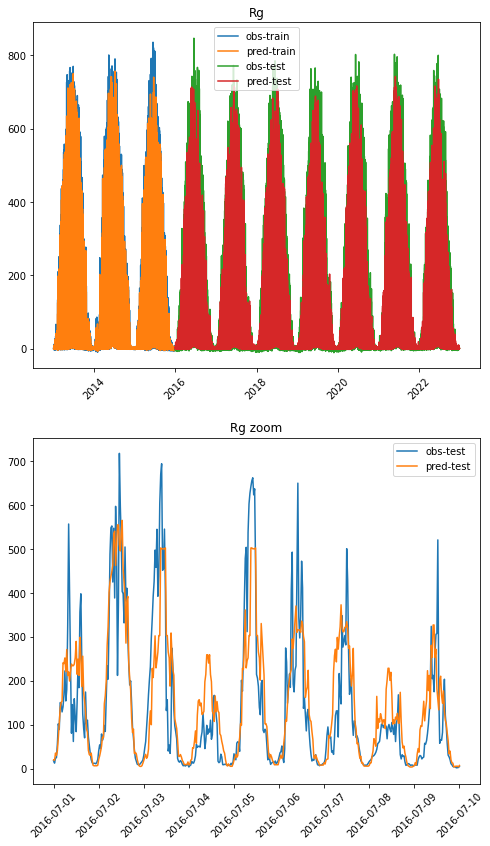

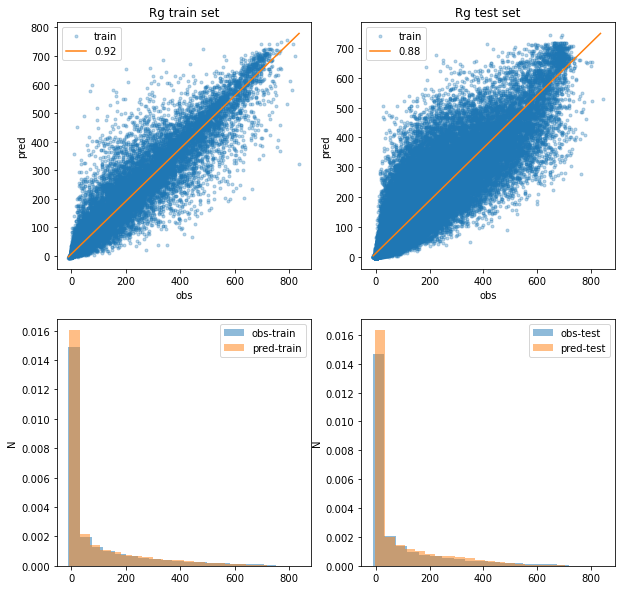

In [7]:
# -- plot figures
%matplotlib inline

#--- this computes histograms and plots
def plothist(ax, y, bins=20, density=True, label='', alpha=0.5):
    h, bin_edges = np.histogram(y, bins=bins, density=density)
    x = bin_edges[:-1]
    w = np.diff(bin_edges)
    
    ax.bar(x, h, width=w, align='edge', alpha=alpha, label=label)
    ax.set_ylabel('N')
    
for k in range(len(v)):
    
    # timeseries
    fig, ax = plt.subplots(2,1, figsize=(8,14))
    ax[0].plot(t, Y[:,k], '-', label='obs-train')
    ax[0].plot(t, Ytpred[:,k], '-', label='pred-train')
    ax[0].plot(tp, Yp[:,k], '-', label='obs-test')
    ax[0].plot(tp, Ypred[:,k], '-', label='pred-test')
    ax[0].set_title(v[k])
    ax[0].xaxis.set_tick_params(rotation=45)
    ax[0].legend()
 
    iv = np.where((tp >= '2016-07-01') & (tp <='2016-07-10'))
    ax[1].plot(tp[iv], np.squeeze(Yp[iv,k]), '-', label='obs-test')
    ax[1].plot(tp[iv], np.squeeze(Ypred[iv,k]), '-', label='pred-test')
    ax[1].set_title(v[k] +' zoom')
    ax[1].xaxis.set_tick_params(rotation=45)
    ax[1].legend()
    
    # scatterplots & distributions
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    ax[0,0].set_title(v[k] + ' train set')
    
    ax[0,0].plot(Y[:,k], Ytpred[:,k], '.', alpha=0.3, label='train')
    ax[0,0].set_xlabel('obs')
    ax[0,0].set_ylabel('pred')
    
    p = np.polyfit(Y[:,k], Ytpred[:,k], 1)
    xx = np.array([min(Y[:,k]), max(Y[:,k])])
    fit = p[1] + p[0] * xx
    ax[0,0].plot(xx, fit, '-', label='%.2f' %p[0])
    ax[0,0].legend()
    
    ax[0,1].set_title(v[k] + ' test set')
    
    ax[0,1].plot(Yp[:,k], Ypred[:,k], '.', alpha=0.3, label='train')
    ax[0,1].set_xlabel('obs')
    ax[0,1].set_ylabel('pred')
    
    p = np.polyfit(Yp[:,k], Ypred[:,k], 1)
    xx = np.array([min(Y[:,k]), max(Y[:,k])])
    fit = p[1] + p[0] * xx
    ax[0,1].plot(xx, fit, '-', label='%.2f' %p[0])
    ax[0,1].legend()
    
    # distributions           
    plothist(ax[1,0], Y[:,k], bins=20, alpha = 0.5, density=True, label='obs-train')
    plothist(ax[1,0], Ytpred[:,k], bins=20, alpha = 0.5, density=True, label='pred-train')
    ax[1,0].legend()   
    plothist(ax[1,1], Yp[:,k], bins=20, alpha = 0.5, density=True, label='obs-test')
    plothist(ax[1,1], Ypred[:,k], bins=20, alpha = 0.5, density=True, label='pred-test')
    ax[1,1].legend()
    

## Predicting Precipitation is likely difficult (diurnal distribution more stochastic process). 

### Build a model for 30min *Prec*

In [8]:
# training data 2013 - 2015
ixt = np.where(x.index.year<2016)[0]
# test data 2016 - 2022
ixp = np.where(x.index.year>=2016)[0]

# target variables: 30min timeseries

v = 'Prec'
Y = x[v].iloc[ixt].values

n_estimators = 10
# --- predictors
# Rg0 is 30min theoretical clear-sky radiation, other are daily. 
# These variables are available / can be computed from everywhere
pcols = ['Rg0', 'Tair', 'Tair_min', 'Tair_max', 'H2O', 'Rg', 'Prec']
X = ddata.iloc[ixt].values
t = x.index[ixt]

# train Random forest

scaler_X = preprocessing.StandardScaler().fit(X)
X_train = scaler_X.transform(X)
    
rf = RandomForestRegressor(n_estimators=n_estimators).fit(X_train, Y)
    
Ytpred = rf.predict(X_train)
print('score (R2) in train set: %.2f' % rf.score(X_train, Y))

# prediction to independent test period
Yp = x[v].iloc[ixp].values
X_pred = scaler_X.transform(Xp)

Ypred = rf.predict(X_pred)
print('score (R2) in test set: %.2f' % rf.score(X_pred, Yp))


score (R2) in train set: 0.67
score (R2) in test set: -0.01


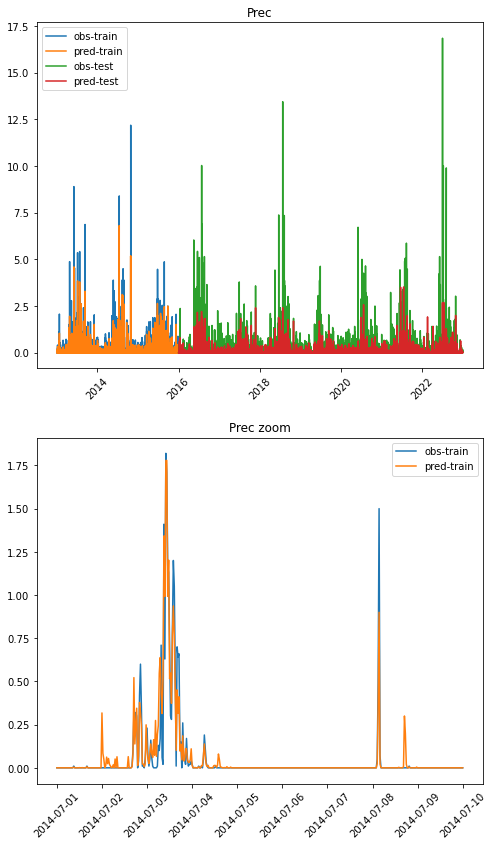

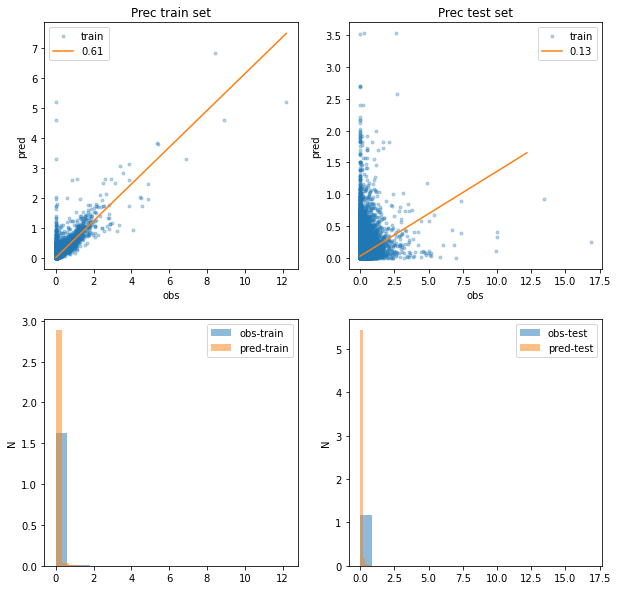

In [15]:
v = 'Prec'

# timeseries
fig, ax = plt.subplots(2,1, figsize=(8,14))
ax[0].plot(t, Y, '-', label='obs-train')
ax[0].plot(t, Ytpred, '-', label='pred-train')
ax[0].plot(tp, Yp, '-', label='obs-test')
ax[0].plot(tp, Ypred, '-', label='pred-test')
ax[0].set_title(v)
ax[0].xaxis.set_tick_params(rotation=45)
ax[0].legend()
 
iv = np.where((t >= '2014-07-01') & (t <='2014-07-10'))
ax[1].plot(t[iv], np.squeeze(Y[iv]), '-', label='obs-train')
ax[1].plot(t[iv], np.squeeze(Ytpred[iv]), '-', label='pred-train')
ax[1].set_title(v +' zoom')
ax[1].xaxis.set_tick_params(rotation=45)
ax[1].legend()
    
# scatterplots & distributions
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].set_title(v + ' train set')
    
ax[0,0].plot(Y, Ytpred, '.', alpha=0.3, label='train')
ax[0,0].set_xlabel('obs')
ax[0,0].set_ylabel('pred')
    
p = np.polyfit(Y, Ytpred, 1)
xx = np.array([min(Y), max(Y)])
fit = p[1] + p[0] * xx
ax[0,0].plot(xx, fit, '-', label='%.2f' %p[0])
ax[0,0].legend()
    
ax[0,1].set_title(v + ' test set')
    
ax[0,1].plot(Yp, Ypred, '.', alpha=0.3, label='train')
ax[0,1].set_xlabel('obs')
ax[0,1].set_ylabel('pred')
    
p = np.polyfit(Yp, Ypred, 1)
xx = np.array([min(Y), max(Y)])
fit = p[1] + p[0] * xx
ax[0,1].plot(xx, fit, '-', label='%.2f' %p[0])
ax[0,1].legend()
    
# distributions           
plothist(ax[1,0], Y, bins=20, alpha = 0.5, density=True, label='obs-train')
plothist(ax[1,0], Ytpred, bins=20, alpha = 0.5, density=True, label='pred-train')
ax[1,0].legend()   
plothist(ax[1,1], Yp, bins=20, alpha = 0.5, density=True, label='obs-test')
plothist(ax[1,1], Ypred, bins=20, alpha = 0.5, density=True, label='pred-test')
ax[1,1].legend()

In [16]:

print('Cumulative Prec (obs/pred) in training data %.2f' % (sum(Y) / sum(Ytpred)))
print('Cumulative Prec (obs/pred) in test data %.2f' % (sum(Yp) / sum(Ypred)))

Cumulative Prec (obs/pred) in training data 0.99
Cumulative Prec (obs/pred) in test data 0.95


### Precipitation patterns can be learned but are not transferable? 